In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# import required packages
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

from ml_preprocess import show_unique_values, custom_ordinal_encoder, custom_onehot_encoder

## Load and Split Data

In [5]:
DATADIR = os.path.join("../data")
os.listdir(DATADIR)

['car.c45-names', 'car.data', 'car.names']

In [6]:
data = pd.read_csv(os.path.join(DATADIR,"car.data"), sep=",", header=None)
data.columns = ["buying","maint","doors","persons","lug_boot","safety","class"]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [7]:
data.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [8]:
show_unique_values(data)

buying: 4 unique values.
['vhigh' 'high' 'med' 'low']

maint: 4 unique values.
['vhigh' 'high' 'med' 'low']

doors: 4 unique values.
['2' '3' '4' '5more']

persons: 3 unique values.
['2' '4' 'more']

lug_boot: 3 unique values.
['small' 'med' 'big']

safety: 3 unique values.
['low' 'med' 'high']

class: 4 unique values.
['unacc' 'acc' 'vgood' 'good']



## Define ML Target, Features and Split Data

In [9]:
# define target y and features X
y = ['buying']
X = [i for i in data.columns if i not in ['buying','persons']]
print('target:', y)
print('features X:', X)

target: ['buying']
features X: ['maint', 'doors', 'lug_boot', 'safety', 'class']


In [10]:
# train-test split
train, test = train_test_split(data[X+y], test_size=0.2, shuffle=True, random_state=42)
train = train.reset_index().drop('index',axis=1)
test = test.reset_index().drop('index',axis=1)
print('train:', train.shape)
print('test:', test.shape)

train: (1382, 6)
test: (346, 6)


## Encode

In [11]:
def init_encoding_dict():   
    # Define ordinal values to encode categorical variables
    value_dict = {}

    value_dict['buying'] = {
        'low':0,
        'med':1,
        'high':2,
        'vhigh':3
    }

    value_dict['maint'] = {
        'low':0,
        'med':1,
        'high':2,
        'vhigh':3
    }

#     value_dict['doors'] = {
#         '2':0,
#         '3':1,
#         '4':2,
#         '5more':3
#     }

#     value_dict['persons'] = {
#         '2':0,
#         '4':1,
#         'more':2
#     }

    value_dict['lug_boot'] = {
        'small':0,
        'med':1,
        'big':2
    }

    value_dict['safety'] = {
        'low':0,
        'med':1,
        'high':2
    }

    value_dict['class'] = {
        'unacc':0,
        'acc':1,
        'good':2,
        'vgood':3
    }
    
    return value_dict

In [12]:
# Encode ordinal columns
ordinal_columns = ['buying', 'maint', 'lug_boot', 'safety', 'class']
value_dict = init_encoding_dict()

print('Before Encoding:')
show_unique_values(train[ordinal_columns])
train = custom_ordinal_encoder(train, ordinal_columns, value_dict)
print('\nAfter Encoding:')
show_unique_values(train[ordinal_columns])

Before Encoding:
buying: 4 unique values.
['vhigh' 'med' 'low' 'high']

maint: 4 unique values.
['vhigh' 'low' 'med' 'high']

lug_boot: 3 unique values.
['big' 'small' 'med']

safety: 3 unique values.
['high' 'med' 'low']

class: 4 unique values.
['unacc' 'acc' 'vgood' 'good']


After Encoding:
buying: 4 unique values.
[3 1 0 2]

maint: 4 unique values.
[3 0 1 2]

lug_boot: 3 unique values.
[2 0 1]

safety: 3 unique values.
[2 1 0]

class: 4 unique values.
[0 1 3 2]



In [13]:
# Treat "doors" as categorical because it is not clear if increasing doors is associated with increasing buying price
# - e.g. sport car has 2 doors but likely to be more expensive
categorical_columns = ["doors"]
train = custom_onehot_encoder(train, categorical_columns)
train.drop(columns=categorical_columns, inplace=True)

In [14]:
# Update features X
X = [i for i in train.columns if i not in ['buying','persons']]
X

['maint',
 'lug_boot',
 'safety',
 'class',
 'doors_2',
 'doors_3',
 'doors_4',
 'doors_5more']

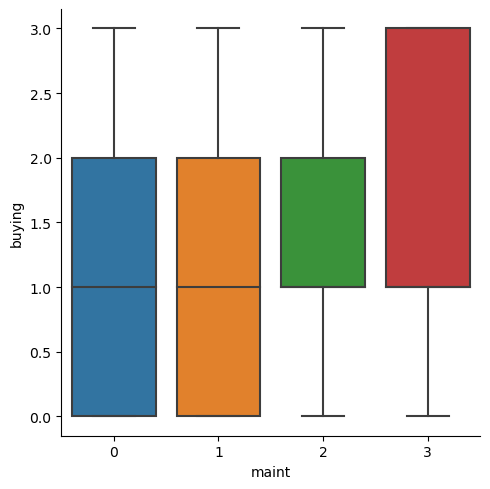

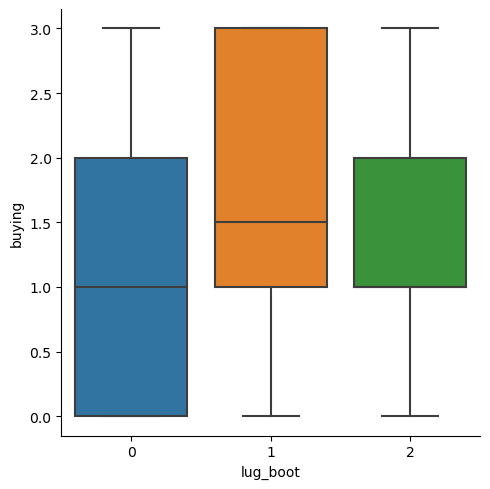

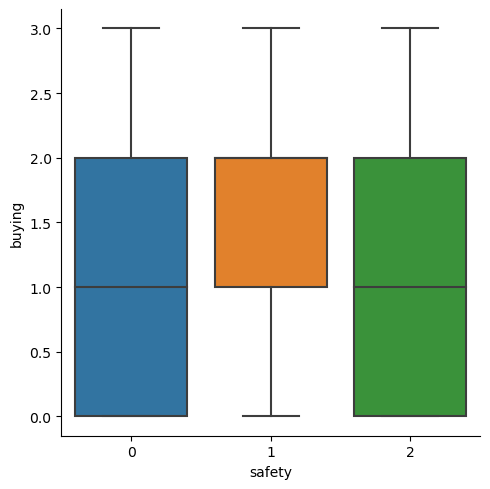

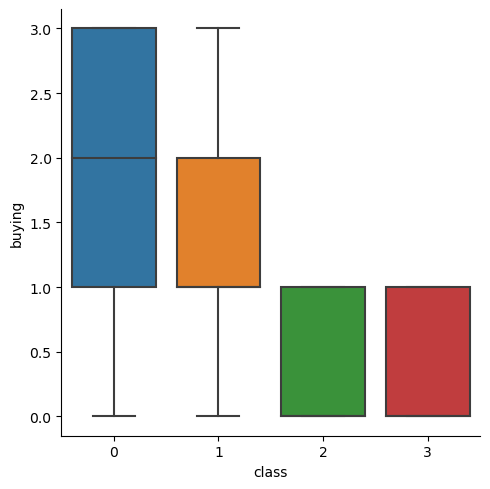

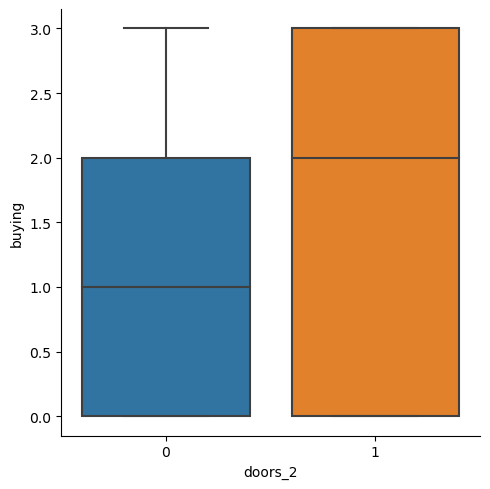

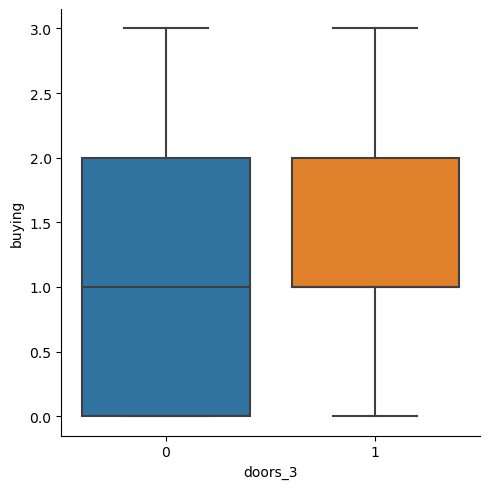

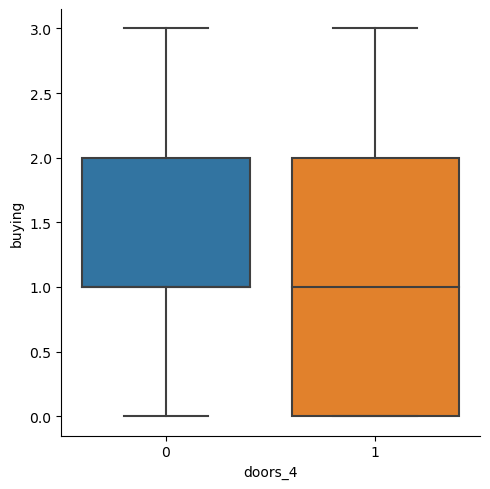

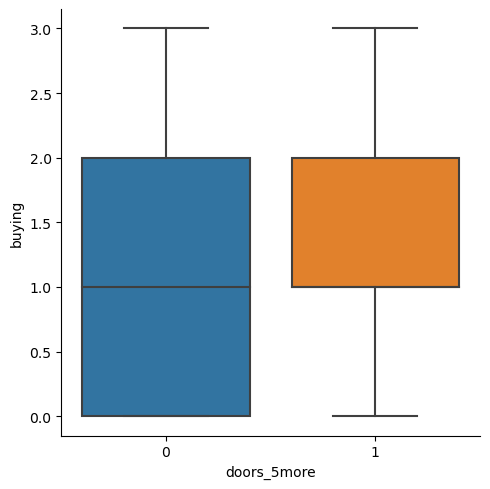

In [15]:
# Explore relationship between features and target via box-plots
for col in X:
    sns.catplot(data=train, x=col, y='buying', kind='box')

## Perform Clustering on Features

In [16]:
# Apply PCA to find number of clusters
# - top 3 components explain 73% of variance --> potentially 3 clusters
pca = PCA(n_components=5)
pcs = pca.fit_transform(train[X])
pca.explained_variance_ratio_.cumsum()

array([0.33507549, 0.55653934, 0.73101849, 0.80814999, 0.87305386])

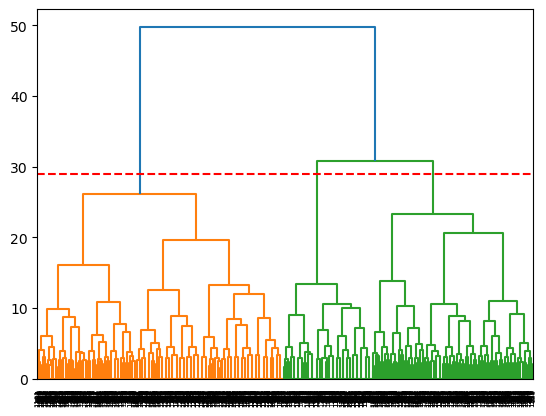

In [17]:
# Apply hierarchical clustering to find number of clusters via dendrogram
# - Dendrogam suggests there could be 3 clusters as well
clusters = shc.linkage(
    train[X], 
    method='ward', 
    metric="euclidean")

shc.dendrogram(Z=clusters)
plt.axhline(y = 29, color = 'r', linestyle = '--')
plt.show()

In [18]:
# Fit KMeans clustering model with 3 clusters to derive label
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)
km.fit(train[X])
train['km_label'] = km.predict(train[X])

In [19]:
# Add clustering label as a feature 
X = X + ['km_label']
X

['maint',
 'lug_boot',
 'safety',
 'class',
 'doors_2',
 'doors_3',
 'doors_4',
 'doors_5more',
 'km_label']

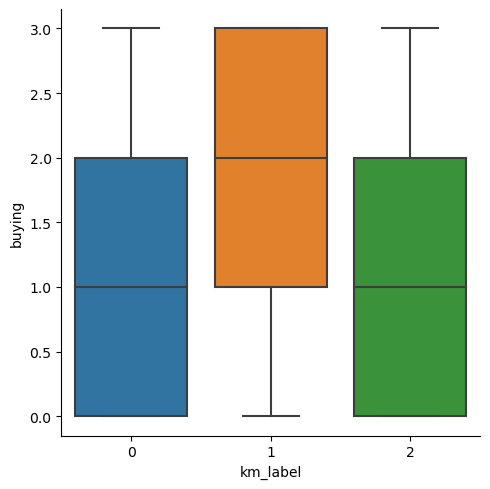

In [20]:
# The new "km_label" feature exhibits some correlation with the target
for col in ['km_label']:
    sns.catplot(data=train, x=col, y='buying', kind='box')

## Define Preprocessing Pipeline Functions

In [21]:
def encode_data(df, ordinal_columns, categorical_columns):
    if "buying" not in df.columns:
        ordinal_columns.remove("buying")
    print('Encoding ordinal columns:', ordinal_columns)
    value_dict = init_encoding_dict()
    df = custom_ordinal_encoder(df, ordinal_columns, value_dict)
    
    print('Encoding categorical columns:', categorical_columns)
    df = custom_onehot_encoder(df, categorical_columns)
    df.drop(columns=categorical_columns, inplace=True)
    
    return df

In [22]:
def label_data(df, features, fitted_kmeans_model):
    print('Apply KMeans clustering model fitted on training set to get new feature km_label')
    df['km_label'] = fitted_kmeans_model.predict(df[features])
    
    return df
    

## Start ML Preprocessing process afresh

In [23]:
# define target y and features X
y = ['buying']
X = [i for i in data.columns if i not in ['buying','persons']]
print('target:', y)
print('features X:', X)

target: ['buying']
features X: ['maint', 'doors', 'lug_boot', 'safety', 'class']


In [24]:
# train-test split
train, test = train_test_split(data[X+y], test_size=0.2, shuffle=True, random_state=42)
train = train.reset_index().drop('index',axis=1)
test = test.reset_index().drop('index',axis=1)
print('train:', train.shape)
print('test:', test.shape)

train: (1382, 6)
test: (346, 6)


In [25]:
ordinal_columns = ['buying', 'maint', 'lug_boot', 'safety', 'class']
categorical_columns = ["doors"]
train = encode_data(train, ordinal_columns, categorical_columns)
test = encode_data(test, ordinal_columns, categorical_columns)

# Update features X
X = [i for i in train.columns if i not in ['buying','persons']]
print('Updated Features After Encoding:', X)

Encoding ordinal columns: ['buying', 'maint', 'lug_boot', 'safety', 'class']
Encoding categorical columns: ['doors']
Encoding ordinal columns: ['buying', 'maint', 'lug_boot', 'safety', 'class']
Encoding categorical columns: ['doors']
Updated Features After Encoding: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more']


In [26]:
# Fit KMeans clustering model on training set with 3 clusters
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)
km.fit(train[X])

KMeans(init='random', n_clusters=3, n_init=10, random_state=0)

In [27]:
# Apply KMeans model to get clustering labels (km_label) on both train and test set
train = label_data(df=train, features=X, fitted_kmeans_model=km)
test = label_data(df=test, features=X, fitted_kmeans_model=km)

Apply KMeans clustering model fitted on training set to get new feature km_label
Apply KMeans clustering model fitted on training set to get new feature km_label


In [28]:
# Add km_label to feature list X
X2 = X + ['km_label']
print('Original Features:', X)
print('Updated Features:', X2)

Original Features: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more']
Updated Features: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more', 'km_label']


## Train and Evaluate ML Model

In [29]:
# define ML models to try out
model_dict = {
    'linreg': LinearRegression(),
    'gbr': GradientBoostingRegressor(),
    'knn':KNeighborsRegressor(),
}

### Try without clustering label

In [30]:
# define X_train, y_train without clustering label
X_train = train[X].values
y_train = train[y].values.flatten()

In [31]:
# train and evaluate ML models using K-fold cross-validation
cv_mean = []
cv_std = []
scoring = ['r2']

for name in model_dict:
    print('training and evaluating {}: {} via K-fold cross-validation...'.format(name, model_dict[name]))
    cv_scores = cross_validate(model_dict[name], X_train, y_train, scoring=scoring)

    cv_scores = pd.DataFrame.from_dict(cv_scores)
    cv_mean.append([name]+cv_scores.mean().to_list())
    cv_std.append([name]+cv_scores.std().to_list())

cv_mean = pd.DataFrame(cv_mean, columns=['model']+list(cv_scores.columns))
cv_std = pd.DataFrame(cv_std, columns=['model']+list(cv_scores.columns))

print()
print('Mean CV scores:')
cv_mean

training and evaluating linreg: LinearRegression() via K-fold cross-validation...
training and evaluating gbr: GradientBoostingRegressor() via K-fold cross-validation...
training and evaluating knn: KNeighborsRegressor() via K-fold cross-validation...

Mean CV scores:


,model,fit_time,score_time,test_r2
0,linreg,0.000774,0.000188,0.088869
1,gbr,0.044631,0.000601,0.155556
2,knn,0.000561,0.001609,-0.081293


### Try with clustering label

In [32]:
X_train = train[X2].values
y_train = train[y].values.flatten()

In [33]:
# train and evaluate ML models using K-fold cross-validation
cv_mean = []
cv_std = []
scoring = ['r2']

for name in model_dict:
    print('training and evaluating {}: {} via K-fold cross-validation...'.format(name, model_dict[name]))
    cv_scores = cross_validate(model_dict[name], X_train, y_train, scoring=scoring)

    cv_scores = pd.DataFrame.from_dict(cv_scores)
    cv_mean.append([name]+cv_scores.mean().to_list())
    cv_std.append([name]+cv_scores.std().to_list())

cv_mean = pd.DataFrame(cv_mean, columns=['model']+list(cv_scores.columns))
cv_std = pd.DataFrame(cv_std, columns=['model']+list(cv_scores.columns))

print()
print('Mean CV scores:')
cv_mean

training and evaluating linreg: LinearRegression() via K-fold cross-validation...
training and evaluating gbr: GradientBoostingRegressor() via K-fold cross-validation...
training and evaluating knn: KNeighborsRegressor() via K-fold cross-validation...

Mean CV scores:


,model,fit_time,score_time,test_r2
0,linreg,0.000890,0.000233,0.136200
1,gbr,0.046471,0.000589,0.159472
2,knn,0.000578,0.001586,-0.073665


### Best model is GradientBoostingRegressor with clustering label as feature

In [36]:
best_model = model_dict['gbr']
print('Best Model =', best_model)

Best Model = GradientBoostingRegressor()


In [37]:
# Retrain best model on the full train partition with km_label as feature
X_train = train[X2].values
y_train = train[y].values.flatten()
best_model.fit(X_train,y_train)

# Estimate of out-of-sample performance on unseen test partition
X_test = test[X2].values
y_test = test[y].values.flatten()
y_pred = np.round(best_model.predict(X_test),0)

print('model score =', best_model.score(X_test,y_test))
print('metrics.r2_score =', metrics.r2_score(y_test, y_pred))
print('metrics.acc =', metrics.accuracy_score(y_test,y_pred))

model score = 0.16716850914043735
metrics.r2_score = 0.015575913644236938
metrics.acc = 0.28901734104046245


## Perform inference on given sample

In [38]:
onehot_columns = [i for i in train.columns if "doors" in i]
onehot_columns

['doors_2', 'doors_3', 'doors_4', 'doors_5more']

In [41]:
sample = ['high','4','big','high','good']
sample_df = pd.DataFrame(sample).transpose()
sample_df.columns = ['maint','doors','lug_boot','safety','class']
sample_df

,maint,doors,lug_boot,safety,class
0,high,4,big,high,good


In [42]:
# Apply encoding
ordinal_columns = ['buying', 'maint', 'lug_boot', 'safety', 'class']
categorical_columns = ["doors"]
sample_df = encode_data(sample_df, ordinal_columns, categorical_columns)
X = [i for i in sample_df.columns if i not in ['buying','persons']]

Encoding ordinal columns: ['maint', 'lug_boot', 'safety', 'class']
Encoding categorical columns: ['doors']


In [43]:
# Add in missing onehot columns
missing_onehot_cols = [i for i in onehot_columns if i not in sample_df.columns]
for col in missing_onehot_cols:
    sample_df[col] = 0
sample_df = sample_df[['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more']]
X = [i for i in sample_df.columns if i not in ['buying','persons']]
print("Features in sample:", X)

Features in sample: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more']


In [44]:
# Get KM clustering label
sample_df = label_data(df=sample_df, features=X, fitted_kmeans_model=km)

Apply KMeans clustering model fitted on training set to get new feature km_label


In [45]:
# Add km_label to feature list X
X2 = X + ['km_label']
print('Original Features:', X)
print('Updated Features:', X2)

Original Features: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more']
Updated Features: ['maint', 'lug_boot', 'safety', 'class', 'doors_2', 'doors_3', 'doors_4', 'doors_5more', 'km_label']


In [46]:
# Estimate of out-of-sample performance on unseen test partition
X_test = sample_df[X2].values
y_pred = int(np.round(best_model.predict(X_test),0))
print("Prediction for buying encoding = ", y_pred)
print("Prediction for buying price = ", [key for key,val in value_dict['buying'].items() if val==y_pred])

Prediction for buying encoding =  0
Prediction for buying price =  ['low']
